# Table of Contents

- [1. Introduction](#1-introduction)
- [2. Load Data](#2-load-data)
  - [2.1. Variable Type & Missing Values](#21-variable-type--missing-values)
- [3. Data Preprocessing](#3-data-preprocessing)
  - [3.1. Train Test Split](#31-train-test-split)
  - [3.2. Check Distribution](#32-check-distribution)
  - [3.3. Caping Extreme Values](#33-caping-extreme-values)
  - [3.4. Heat Map](#34-heat-map)
- [4. ML Models with Feature Selection](#4-ml-models-with-feature-selection)
  - [Model 0: All Features](#model-0-all-features)
  - [Model 1: Lenient Feature Selection](#model-1-lenient-feature-selection)
  - [Model 2: Moderate Feature Selection](#model-2-moderate-feature-selection)
  - [Model 3: Strict Feature Selection](#model-3-strict-feature-selection)
  - [Compare Model Performance](#compare-model-performance)
- [5. ML Models with PCA](#5-ml-models-with-pca)
  - [5.1. Number of Components & Explained Variance](#51-number-of-components--explained-variance)
  - [5.2. PCA Model Performance](#52-pca-model-performance)
    - [5.2.1. PCA with SVM](#521-pca-with-svm)
    - [5.2.2. PCA with Logistic Regression](#522-pca-with-logistic-regression)
- [6. Final Model](#6-final-model)
  - [6.1. Evolutionary Algorithm Model Selection](#61-evolutionary-algorithm-model-selection)
  - [6.2. BUT!](#62-but)
- [7. Conclusion](#7.-conclusion)
- [References](#references)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# 1. Introduction

This notebook is part of Hao Chen's machine learning project for LPI Artificial intelligence (2023-2024). It builds machine learning algorithms to predict the winning team of League of Legends ranked games, using the first 10 mins game stats. The data was obtained from Kaggle with the [link](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min) here.

First, I split the data into train and test datasets to avoid data leakage. Then, I inspected the distributions of variables of the training set and capped extreme values found in these two variables: blueWardsPlaced and redWardsPlaced. The heatmap shows severe collinearity in this data.

Second, I compared the performance across several common machine learning models, namely, logistic regression, linear support vector machine, naive bayes classifier, MLP, KNN, and random forest. I ran these models using variables with different levels of feaure selection, as shown in the table below. The performance was measured by the averaged validation accuracy score on validation set using the 5-fold cross-validation. It turned out that linear SVM, logistic regression, naive bayes classifier, and MLP all achieved consistent accuracy rate (0.72-0.73), regardless of the level of feature selection.


| Selection Method   | Features Kept                                | Removed Correlated Features (Collinearity)                     |
|--------------------|----------------------------------------------|--------------------------------------|
| All Features       | All                                          | None                                 |
| Lenient Selection  | Correlation with target > 0.2                | Correlation among features > 0.9     |
| Moderate Selection | Correlation with target > 0.3                | Correlation among features > 0.8     |
| Strict Selection| Correlation with target > 0.4                | Correlation among features > 0.7     |

Third, I used principal component analysis to reduce data dimensionaity and ran linear SVM and logistic regression on the reduced data. Interestingly, even though using just 3 components explained over 95% of the data variance, the accuracy of the model only surpassed 72% when I used more than 7 components.


Finally, I used evolutionary algorithm to tune the hyperparameters of a linear SVM with PCA transformed data. It achieved ~0.73 accuracy on the test set. However, a linear SVM with all features can already achieve a similar level of accuracy.

# 2. Load Data

In [4]:
file_path = './data/high_diamond_ranked_10min.csv'

In [5]:
# Load Data
df = pd.read_csv(file_path)
df = df.drop_duplicates()

In [6]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

Drop repeated columns, i.e., columns representing the same variables, e.g.,
- blueDeaths = redKills, blueKills = redDeaths
- blueFirstBlood = 1 - redFirstBlood
- blue/red Gold per min * 10 = blue/red Total Gold
- blue/red CS per min * 10 = blue/red Total Gold
- redGoldDiff = -blueGoldDiff
- redExperienceDiff = -blueExperienceDiff

In [7]:
df_cleaned = df.copy()
drop_columns = [
    'gameId', 'redDeaths', 'redKills', 'redFirstBlood', 'redGoldDiff', 'redExperienceDiff',
    'blueCSPerMin', 'blueGoldPerMin', 'redCSPerMin', 'redGoldPerMin'
    ]
df_cleaned = df_cleaned.drop(drop_columns, axis=1)

In [8]:
df_cleaned.shape

(9879, 30)

## 2.1. Variable type & Missing Values

All variables are already numerical, no need for converting data type.

No explicit missing values.

In [9]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

# 3. Data Preprocessing

## 3.1. Train test split

Split dataframe into train and test datasets, to avoid leaking data.

In [10]:
X = df_cleaned.iloc[:, 1:]
y = df_cleaned.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
train_data = pd.concat([y_train, X_train], axis=1)

## 3.2. Check distribution

In [12]:
train_data.iloc[:, :18].describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff
count,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.00000,7903.000000
mean,0.498165,22.308617,2.819815,0.502720,6.176136,6.136910,6.634569,0.552702,0.364419,0.188283,0.051246,16502.738074,6.915349,17927.420347,216.667848,50.572947,12.30558,-33.938125
std,0.500028,18.157256,2.172730,0.500024,3.027229,2.945636,4.080819,0.625514,0.481297,0.390963,0.242906,1542.778404,0.307513,1206.677567,21.880809,9.936305,2464.09126,1923.614589
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,-10830.00000,-9333.000000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15407.000000,6.800000,17167.500000,202.000000,44.000000,-1605.00000,-1297.000000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16399.000000,7.000000,17949.000000,218.000000,50.000000,7.00000,-26.000000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17469.000000,7.200000,18729.000000,232.000000,56.000000,1616.00000,1203.000000
max,1.000000,250.000000,25.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,11467.00000,8265.000000


In [13]:
train_data.iloc[:, 18:].describe()

,redWardsPlaced,redWardsDestroyed,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
count,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000
mean,22.309250,2.739213,6.655194,0.570922,0.409971,0.160952,0.045299,16490.432494,6.925775,17961.358471,217.431482,51.316715
std,18.446013,2.189559,4.074189,0.626747,0.491859,0.367509,0.223234,1497.618635,0.305592,1196.809348,21.971273,10.022780
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000
25%,14.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15424.000000,6.800000,17207.500000,203.500000,44.000000
50%,16.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16376.000000,7.000000,17972.000000,218.000000,51.000000
75%,20.000000,4.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17424.500000,7.200000,18754.000000,233.000000,57.000000
max,276.000000,24.000000,28.000000,2.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,282.000000,92.000000


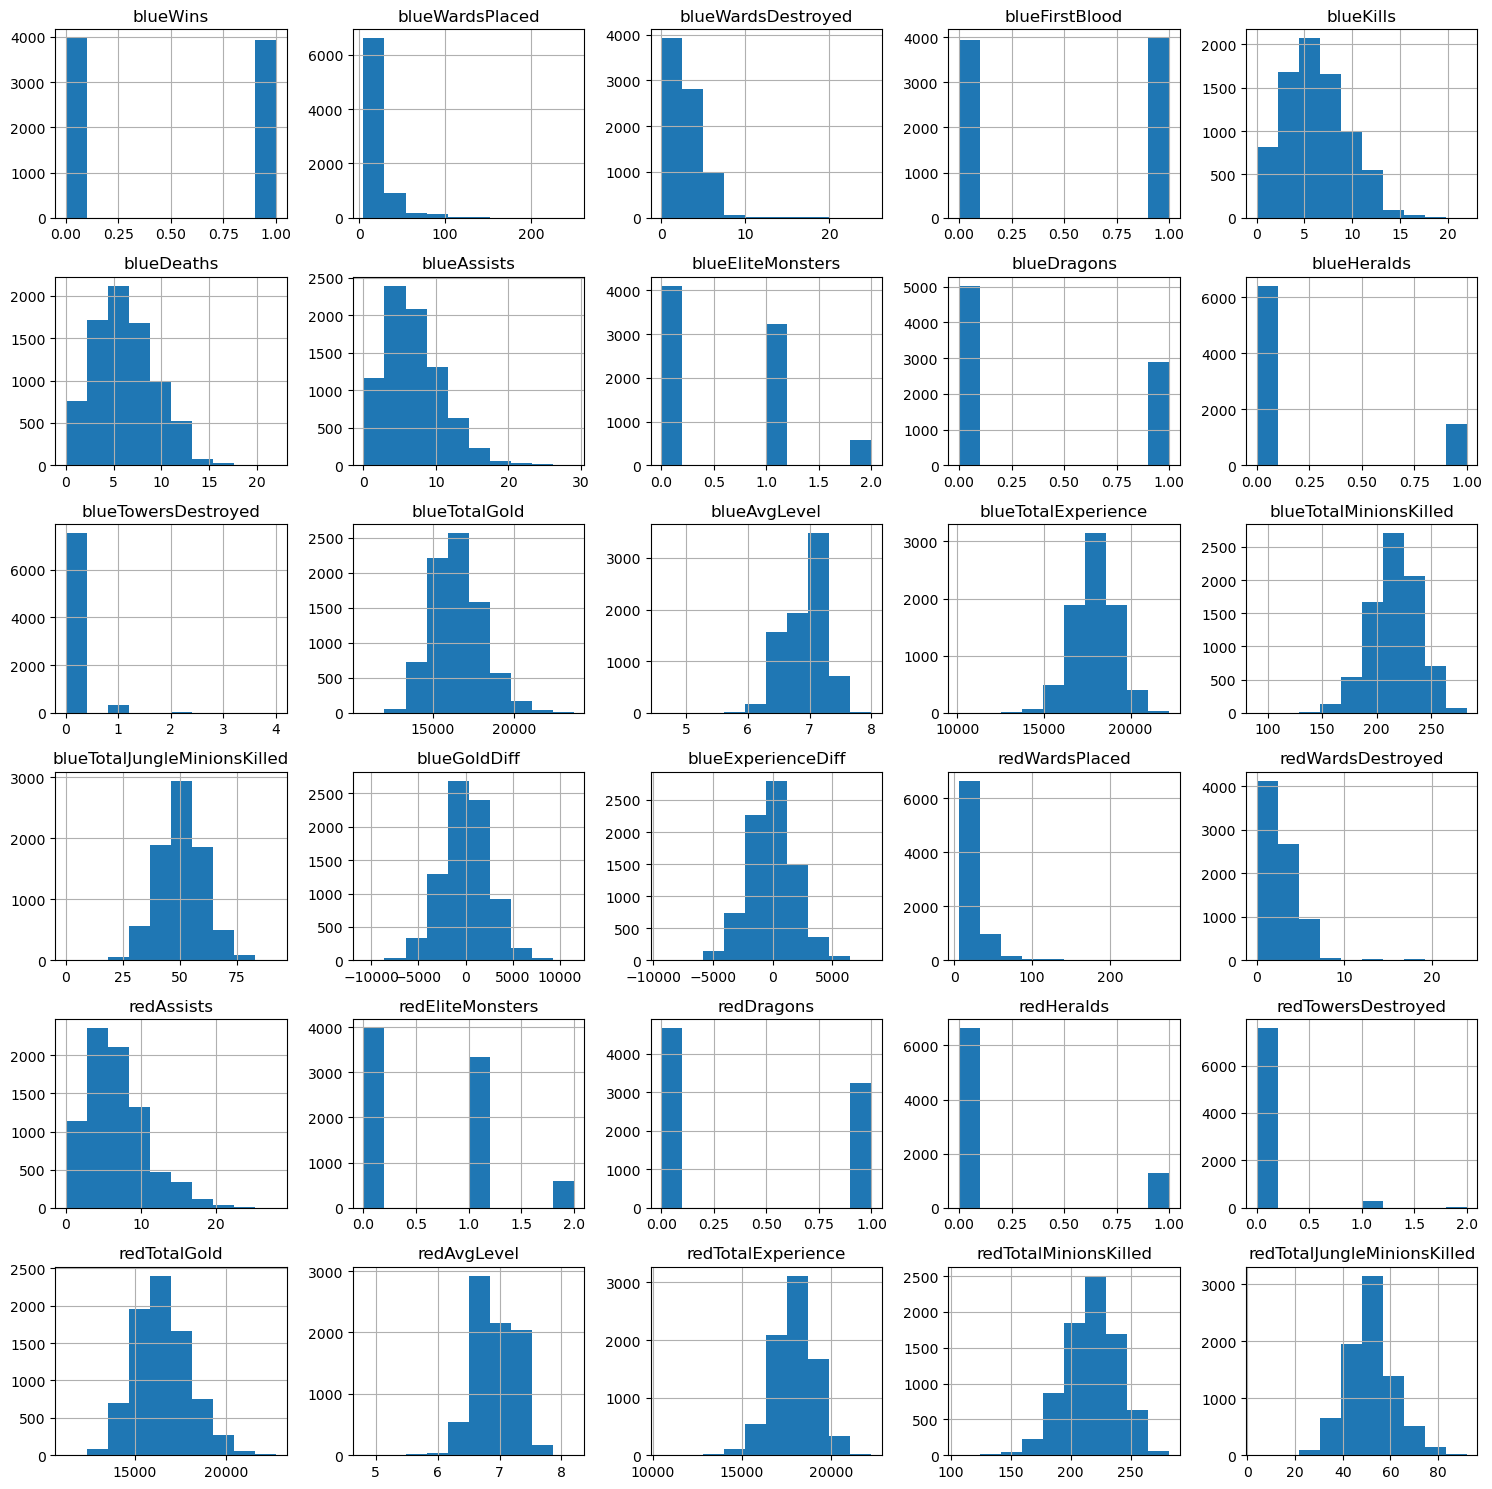

In [14]:
train_data.hist(figsize=(15, 15))
plt.tight_layout()
plt.show()

**Balanced Classes**

The number of two values of the target variable are roughly equal, indicating balanced classes.

**Distributions**

Most continuous variables are follow normal distribution, with various degrees of skewness. I will standardise them using scaling later in ML algorithm. 

**Outliers**

The number of blue and red wards have extreme large values. After consulting LOL rules, a passoinate LOL player friend, and some online resources, it can be due to several reasons:
- According to the author of this [Kaggle post](https://www.kaggle.com/code/servietsky/league-of-legends-what-to-do-in-first-10-min), some players might place a lot of wards when they are waiting for being defeated.
- Some players might have abused bugs to get a huge number of wards, e.g., [see this youtube video on a bug](https://www.youtube.com/watch?v=nvFDbBbfQF0).
- Some players could potentially place an indefinite number wards at the fountain of their home team, after obtaining a special equipment. But this is not a normal behaviour.

I'll cap these values later in the data preprocessing.

## 3.3. Caping extreme values

As explained previously, the number of wards placed have extreme values due to bug abusing. I'll cap these extreme values.

In [15]:
# Define a function to calculate upper bound for capping
def calculate_upper_bouns(dataframe, column, factor=1.5):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR
    return upper_bound

In [16]:
# Calculate upper bound
blue_ward_upper_bound = calculate_upper_bouns(X_train, 'blueWardsPlaced')
red_ward_upper_bound = calculate_upper_bouns(X_train, 'redWardsPlaced')
print(f'Blue team upper bound: {blue_ward_upper_bound}')
print(f'Red team upper bound: {red_ward_upper_bound}')

Blue team upper bound: 29.0
Red team upper bound: 29.0


In [17]:
# Define a function for data preprocessing
def cap_values_upper_and_indicator(dataframe, column_name, upper_bound):
    """
    Caps values at the upper bound for a specified column in a DataFrame and creates an indicator column.
    """
    # Create an indicator column for upper bound capping
    indicator_column_name = column_name + '_upper_capped'
    dataframe[indicator_column_name] = dataframe[column_name] > upper_bound
    dataframe[indicator_column_name] = dataframe[indicator_column_name].astype(int)
    
    # Cap the values at the upper bound
    dataframe[column_name] = dataframe[column_name].clip(upper=upper_bound)

In [18]:
cap_values_upper_and_indicator(X_train, 'blueWardsPlaced', blue_ward_upper_bound)
cap_values_upper_and_indicator(X_test, 'blueWardsPlaced', blue_ward_upper_bound)
cap_values_upper_and_indicator(X_train, 'redWardsPlaced', red_ward_upper_bound)
cap_values_upper_and_indicator(X_test, 'redWardsPlaced', red_ward_upper_bound)

In [19]:
# Sanity check
X_train['blueWardsPlaced'].unique()
X_train['blueWardsPlaced_upper_capped'].unique()

array([0, 1])

array([[<Axes: title={'center': 'blueWardsPlaced'}>,
        <Axes: title={'center': 'redWardsPlaced'}>]], dtype=object)

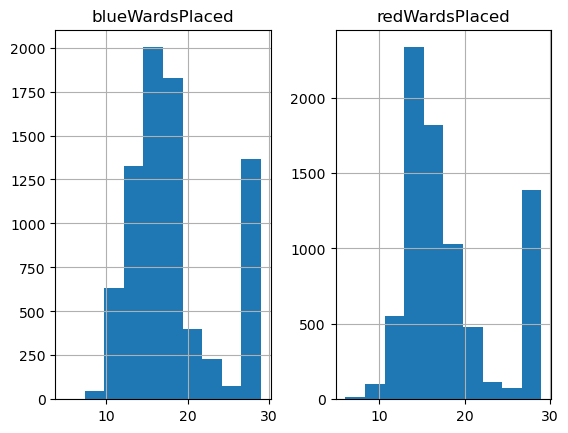

In [20]:
X_train[['blueWardsPlaced', 'redWardsPlaced']].hist()

## 3.4. Heat map

Calculate correlation matrix and visualise it using heat map

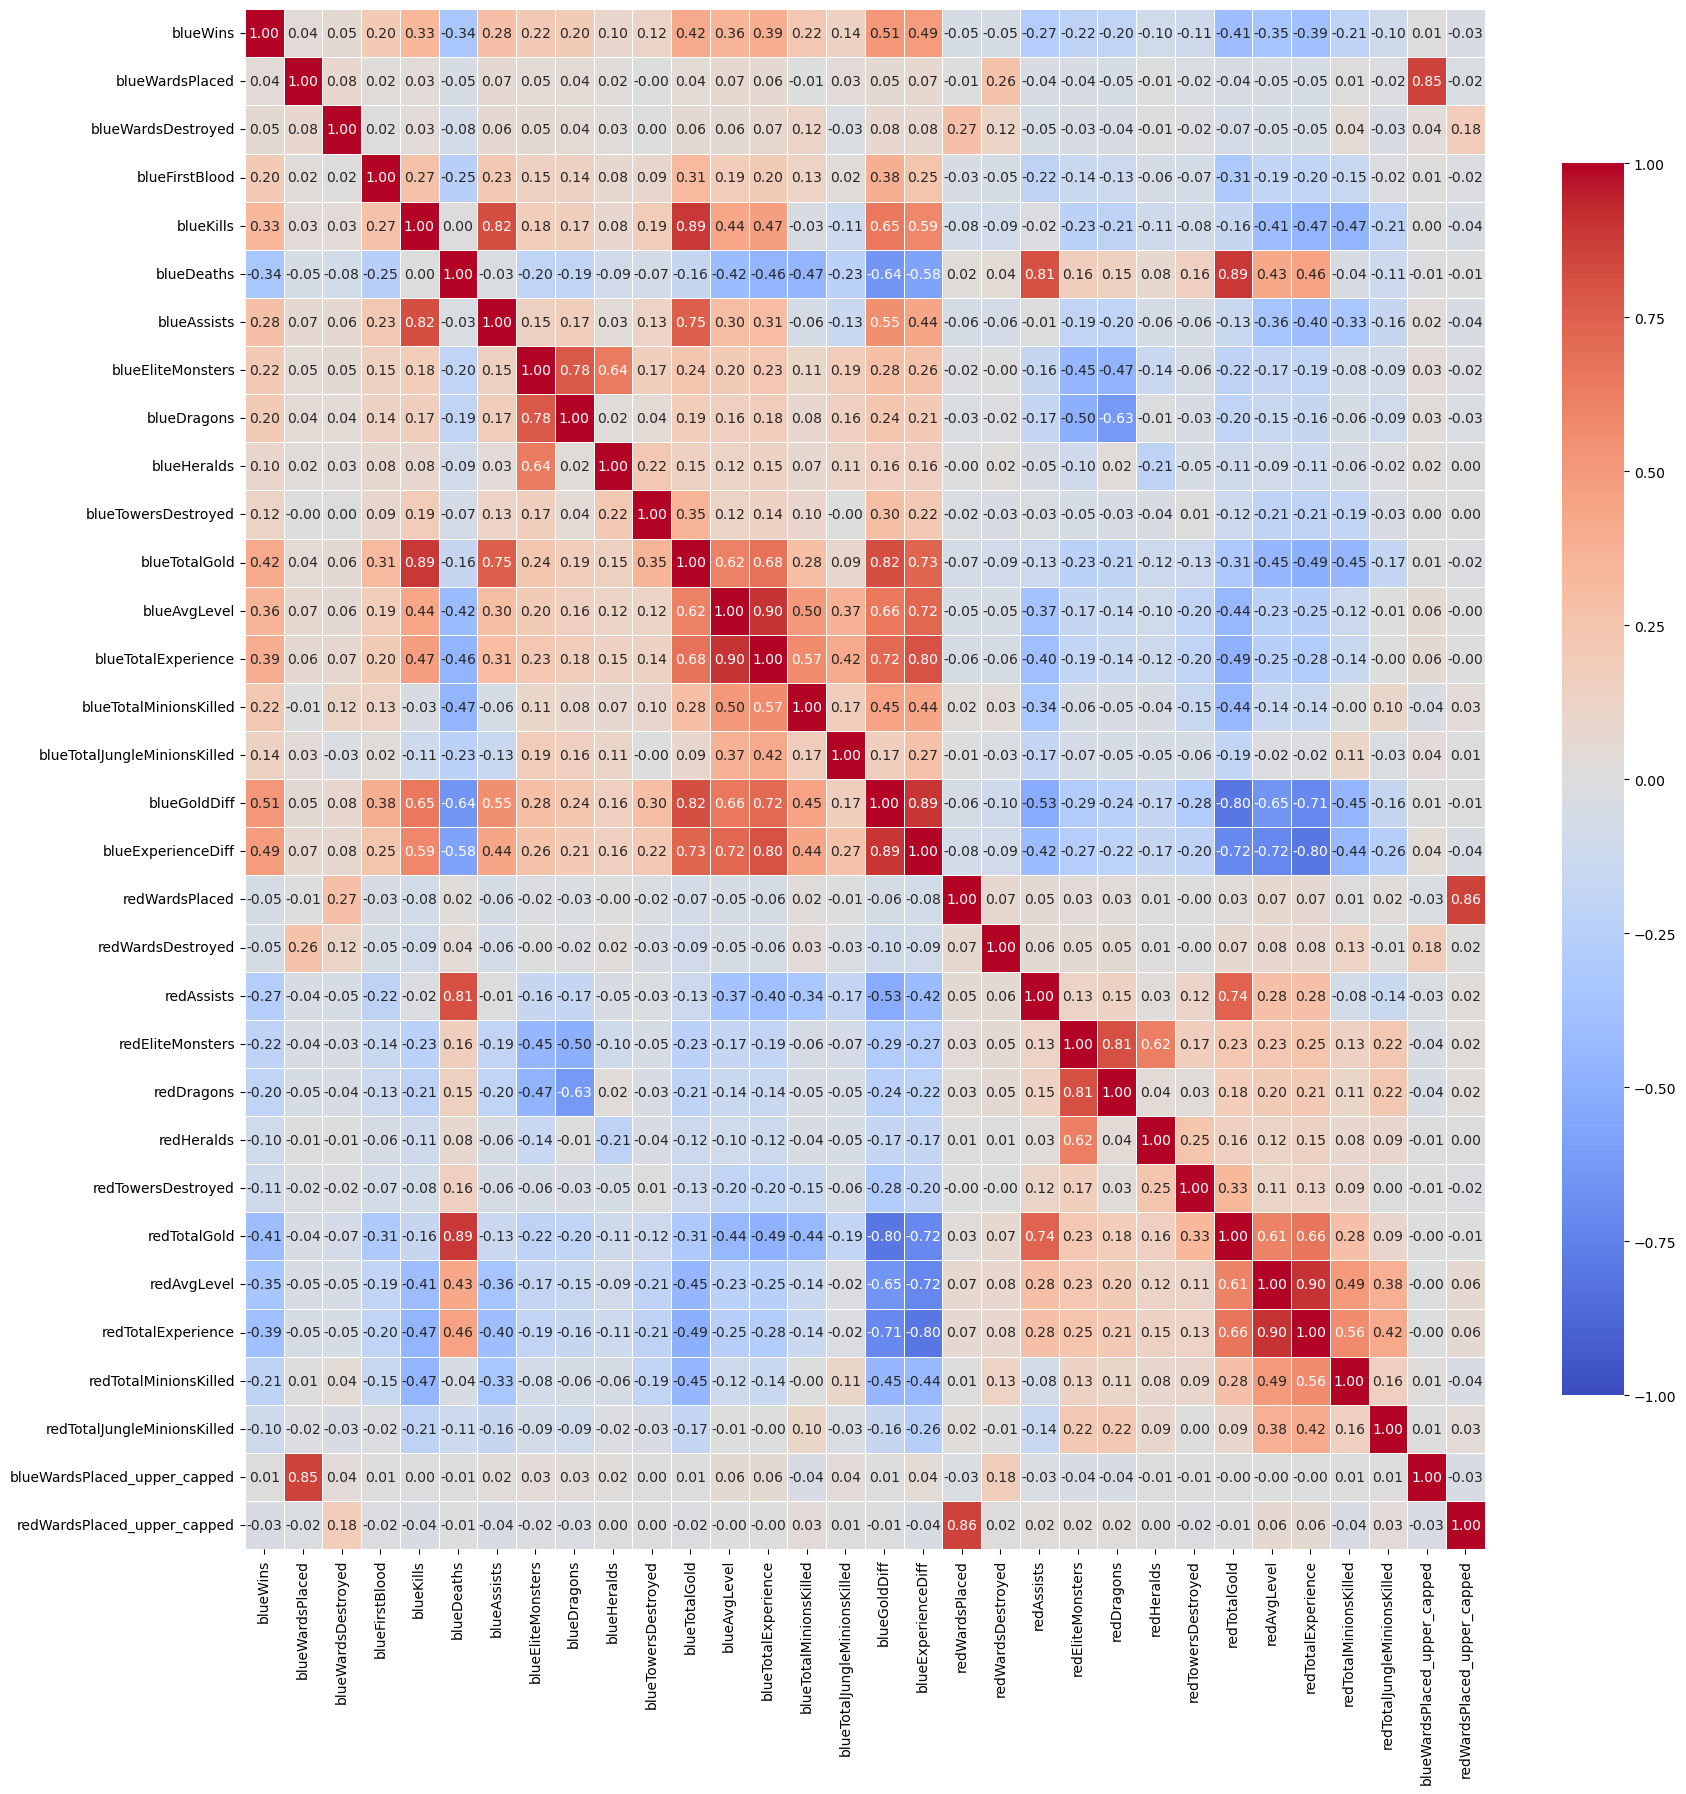

In [21]:
train_data = pd.concat([y_train, X_train], axis=1)

# Calculate the Correlation Matrix
corr = train_data.corr(method='pearson')

# Create the heatmap using Seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', 
            vmin=-1, vmax=1, 
            fmt=".2f", linewidths=.5, 
            cbar_kws={"shrink": .8}) 
plt.show()

### No strong predictor
The heatmap reveals no strong very predictors for blueWins. The highest r between predictors and the target variable was around 0.5.

### Multicollinearity
The heatmap reveals multicollinearity between variables, especially among good predictors for the target variable.

E.g.,
- blueTotalGlod, blueAvgLevel, blueTotalExperiences were associated with blueWins (rho >0.3), but they were also mutually associated with each other (r > 0.60).
- Another sets of good predictors, blueGoldDiff & blueExperienceDiff, were associated with each other (rho = 0.88) and also with the aforementioned three variables (r > 0.60)

# 4. ML Models with Feature Selection

## Model 0: all features

In [22]:
# Naive Bayes Pipeline
nb_pipeline = make_pipeline(MinMaxScaler(), GaussianNB())

# SVM Pipeline
svm_pipeline = make_pipeline(MinMaxScaler(), LinearSVC(dual='auto', max_iter=5000))

# KNN Pipeline
knn_pipeline = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Random Forest Pipeline
rf_pipeline = make_pipeline(MinMaxScaler(), RandomForestClassifier())

# MLP Pipeline
mlp_pipeline = make_pipeline(MinMaxScaler(), MLPClassifier(max_iter=1000))

# Logistiic Regression Pipeline
lr_pipeline = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000))


In [23]:
nb_scores = cross_val_score(nb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=5, scoring='accuracy')
knn_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='accuracy')
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
mlp_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=5, scoring='accuracy')
lr_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='accuracy')

## Model 1: lenient feature selection

**Low Threshold for Redundant Features Removal**

Features with a very low correlation with the target variable (i.e., less than 0.2) are removed.

In [24]:
# Follow features are obtained by inspecting previous heatmap
significant_features = [
    'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
    'blueEliteMonsters', 'blueDragons','blueTotalGold', 'blueAvgLevel',
    'blueTotalExperience', 'blueTotalMinionsKilled', 'blueGoldDiff',
    'blueExperienceDiff', 'redAssists', 'redEliteMonsters', 'redDragons',
    'redTotalGold', 'redAvgLevel', 'redTotalExperience',
    'redTotalMinionsKilled']

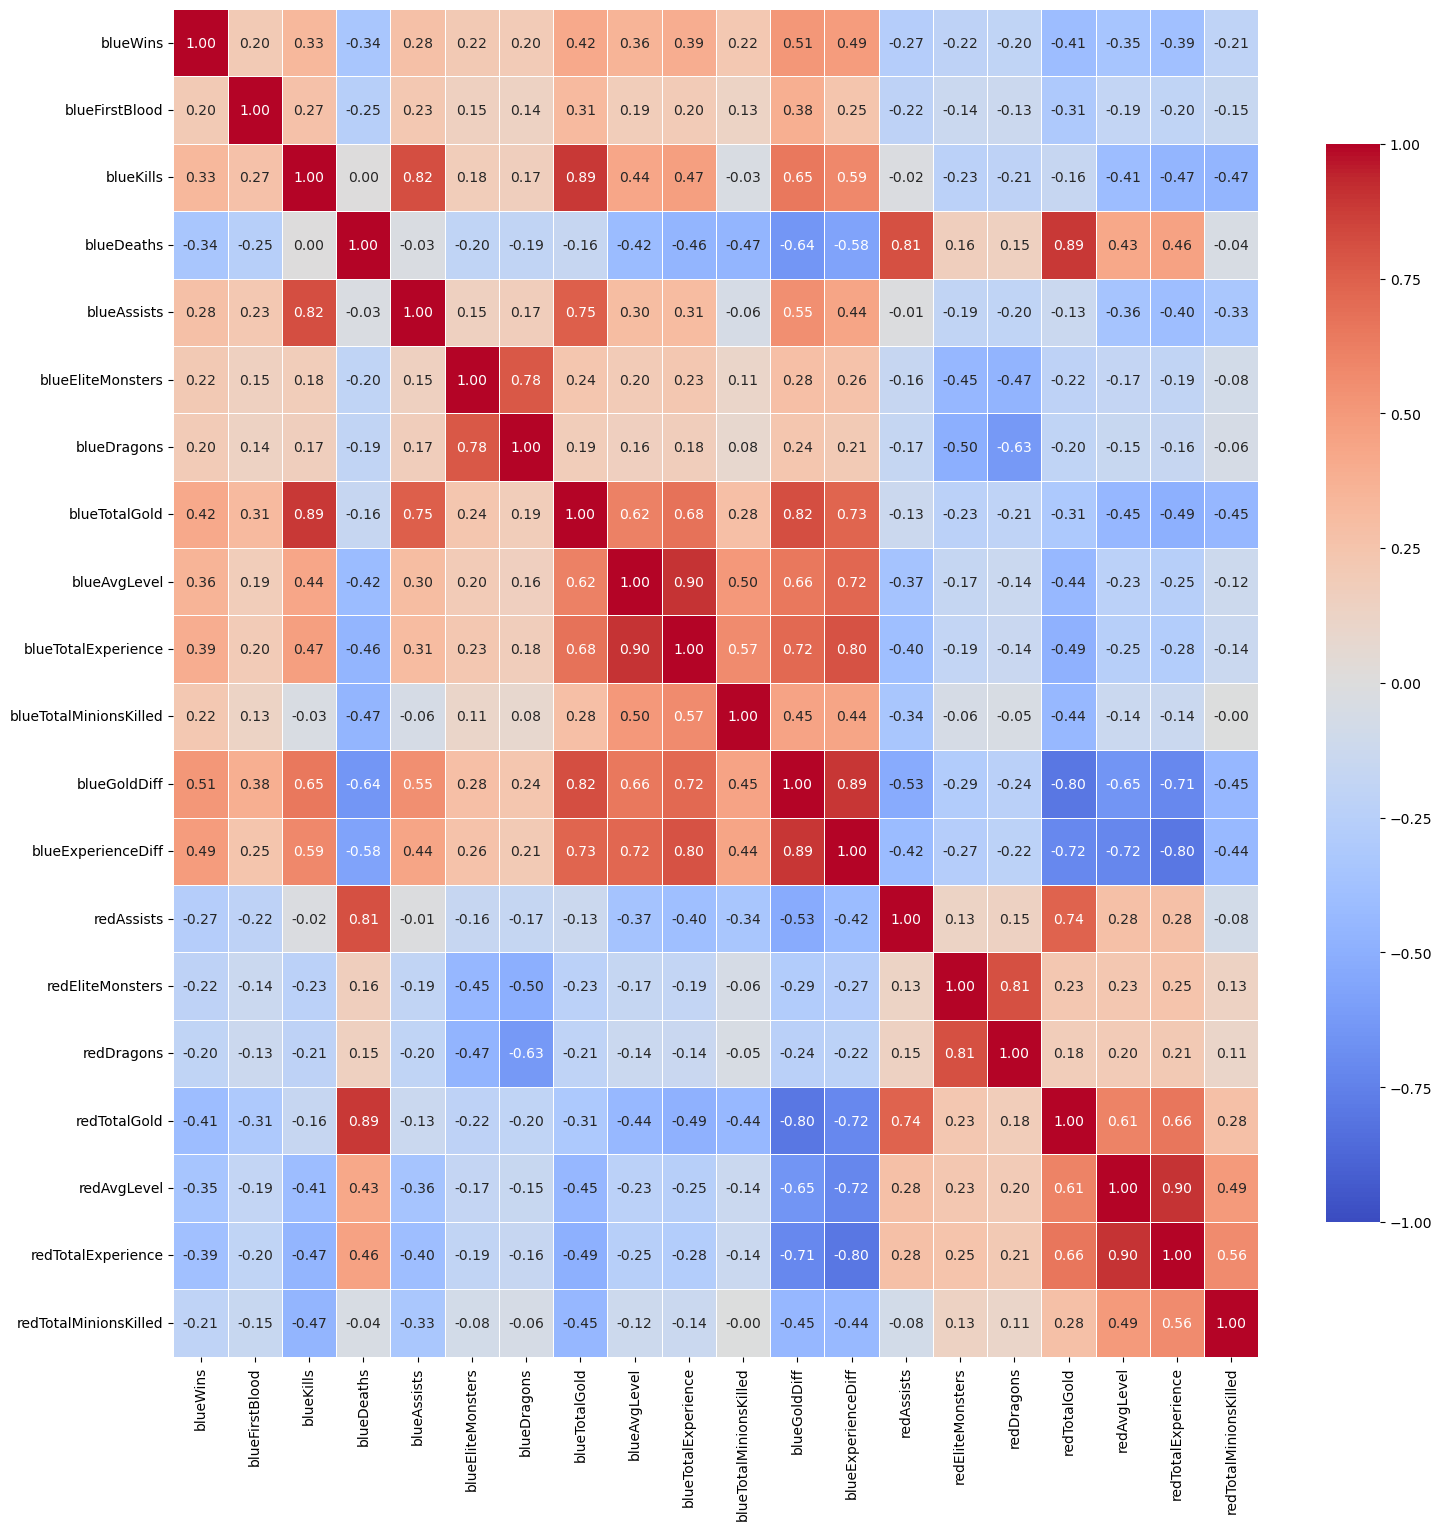

In [25]:
train_data = pd.concat([y_train, X_train], axis=1)

# Calculate the Correlation Matrix
corr = train_data[(['blueWins'] + significant_features)].corr(method='pearson')

# Create the heatmap using Seaborn
plt.figure(figsize=(17.5, 17.5))
sns.heatmap(corr, annot=True, cmap='coolwarm', 
            vmin=-1, vmax=1, 
            fmt=".2f", linewidths=.5, 
            cbar_kws={"shrink": .8}) 
plt.show()


**High Threshold for Redundant Features Removal**

If the correlation between any two independent variables is higher than 0.9, one of them will be removed. The ones will lower correlation with the target variable will be removed.



In [26]:
removed_features = ['blueAvgLevel', 'redAvgLevel']
selected_features = [f for f in significant_features if f not in removed_features]
selected_features

['blueFirstBlood',
 'blueKills',
 'blueDeaths',
 'blueAssists',
 'blueEliteMonsters',
 'blueDragons',
 'blueTotalGold',
 'blueTotalExperience',
 'blueTotalMinionsKilled',
 'blueGoldDiff',
 'blueExperienceDiff',
 'redAssists',
 'redEliteMonsters',
 'redDragons',
 'redTotalGold',
 'redTotalExperience',
 'redTotalMinionsKilled']

In [27]:
# Naive Bayes Pipeline
nb_pipeline = make_pipeline(MinMaxScaler(), GaussianNB())

# SVM Pipeline
svm_pipeline = make_pipeline(MinMaxScaler(), LinearSVC(dual='auto', max_iter=5000))

# KNN Pipeline
knn_pipeline = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Random Forest Pipeline
rf_pipeline = make_pipeline(MinMaxScaler(), RandomForestClassifier())

# MLP Pipeline
mlp_pipeline = make_pipeline(MinMaxScaler(), MLPClassifier(max_iter=1000))

# Logistic Regression Pipeline
lr_pipeline = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000))

In [28]:
nb_scores_relax = cross_val_score(nb_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
svm_scores_relax = cross_val_score(svm_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
knn_scores_relax = cross_val_score(knn_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
rf_scores_relax = cross_val_score(rf_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
mlp_scores_relax = cross_val_score(mlp_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
lr_scores_relax = cross_val_score(lr_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')

## Model 2: moderate feature selection

**Moderate Threshold for Redundant Features Removal**

Features with a very low correlation with the target variable (i.e., less than 0.3) are removed.

In [29]:
# Follow features are obtained by inspecting previous heatmap
significant_features = [
    'blueKills', 'blueDeaths', 'blueTotalGold', 'blueAvgLevel',
    'blueTotalExperience', 'blueGoldDiff', 'blueExperienceDiff',
    'redTotalGold', 'redAvgLevel', 'redTotalExperience']

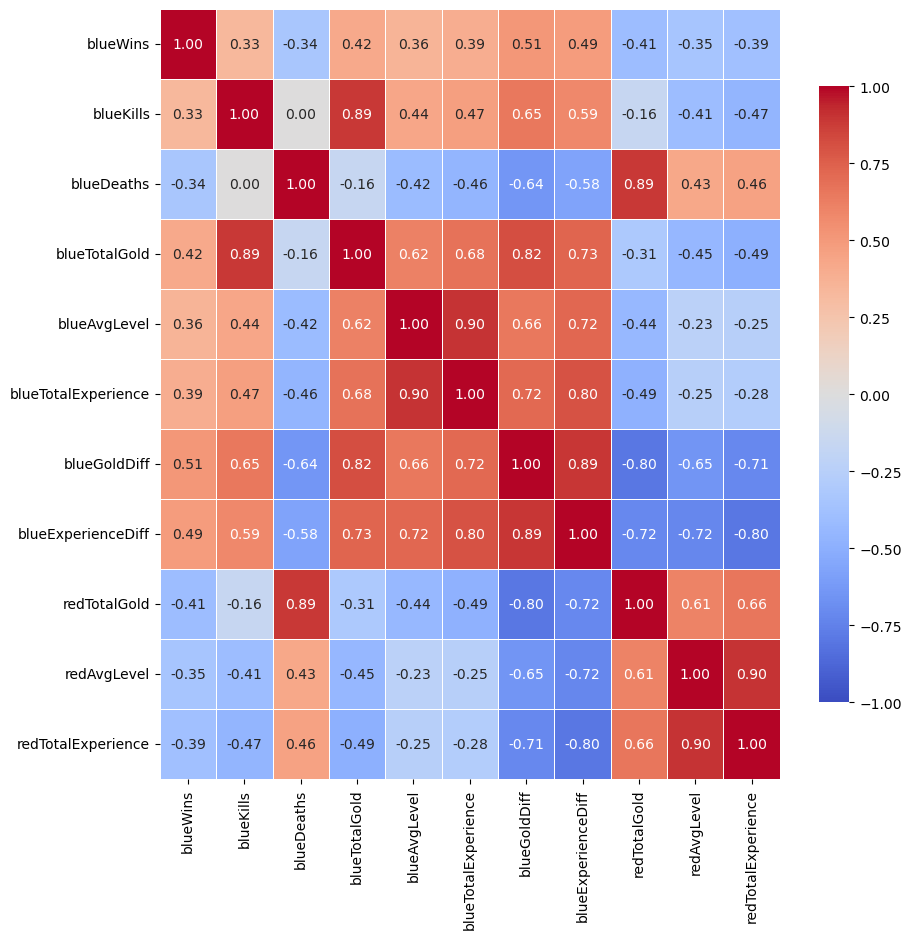

In [30]:
train_data = pd.concat([y_train, X_train], axis=1)

# Calculate the Correlation Matrix
corr = train_data[(['blueWins'] + significant_features)].corr(method='pearson')

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', 
            vmin=-1, vmax=1, 
            fmt=".2f", linewidths=.5, 
            cbar_kws={"shrink": .8}) 
plt.show()


**Medium Threshold for Redundant Features Removal**

If the correlation between any two independent variables is higher than 0.8, one of them will be removed. The ones will lower correlation with the target variable will be removed.

To implement this algorithm, I first create a network of associated variables. Then, I start to delete the variables associated with blueGoldDiff, as it was the best predictor for the target variable. This eliminates blueTotalGold, redTotalGold, and blueExperienceDiff. 

For the remaining pairs of associated variables, I eliminated blueAvgLevel and redAvgLevel. 

**Note:** I personally feel that this approach will cause overfitting.


In [31]:
removed_features = [
    'blueTotalGold', 'redTotalGold', 'blueExperienceDiff',
    'blueAvgLevel', 'redAvgLevel']
selected_features = [f for f in significant_features if f not in removed_features]
selected_features

['blueKills',
 'blueDeaths',
 'blueTotalExperience',
 'blueGoldDiff',
 'redTotalExperience']

In [32]:
# Naive Bayes Pipeline
nb_pipeline = make_pipeline(MinMaxScaler(), GaussianNB())

# SVM Pipeline
svm_pipeline = make_pipeline(MinMaxScaler(), LinearSVC(dual='auto', max_iter=5000))

# KNN Pipeline
knn_pipeline = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Random Forest Pipeline
rf_pipeline = make_pipeline(MinMaxScaler(), RandomForestClassifier())

# MLP Pipeline
mlp_pipeline = make_pipeline(MinMaxScaler(), MLPClassifier(max_iter=1000))

# Logistic Regression Pipeline
lr_pipeline = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000))

In [33]:
nb_scores_moderate = cross_val_score(nb_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
svm_scores_moderate = cross_val_score(svm_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
knn_scores_moderate = cross_val_score(knn_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
rf_scores_moderate = cross_val_score(rf_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
mlp_scores_moderate = cross_val_score(mlp_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
lr_scores_moderate = cross_val_score(lr_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')

## Model 3: strict feature selection

**Moderate Threshold for Redundant Features Removal**

Features with a very low correlation with the target variable (i.e., less than 0.4) are removed.

In [34]:
# Follow features are obtained by inspecting previous heatmap
significant_features = [
'blueTotalGold', 'blueGoldDiff',
'blueExperienceDiff', 'redTotalGold']

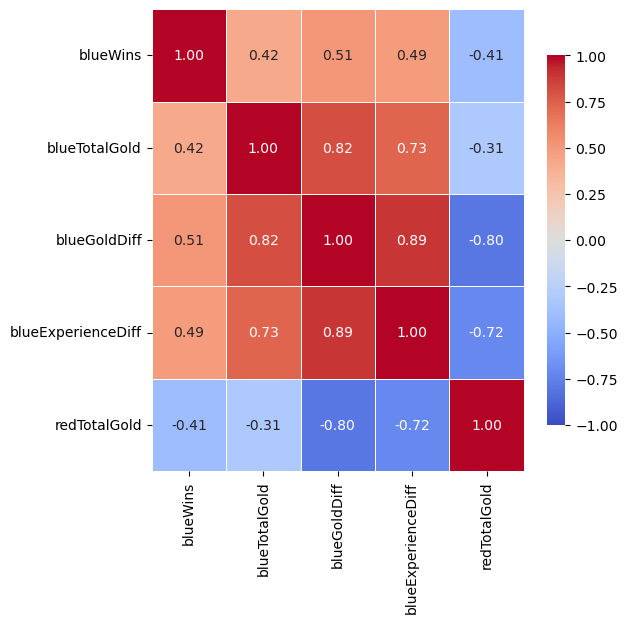

In [35]:
train_data = pd.concat([y_train, X_train], axis=1)

# Calculate the Correlation Matrix
corr = train_data[(['blueWins'] + significant_features)].corr(method='pearson')

# Create the heatmap using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', 
            vmin=-1, vmax=1, 
            fmt=".2f", linewidths=.5, 
            cbar_kws={"shrink": .8}) 
plt.show()

**Strict Threshold for Redundant Features Removal**

If the correlation between any two independent variables is higher than 0.7, one of them will be removed. The ones will lower correlation with the target variable will be removed.

To implement this algorithm, I first create a network of associated variables. Then, I start to delete the variables associated with blueGoldDiff, as it was the best predictor for the target variable. This eliminates all three other variables, blueTotalGold, redTotalGold, and blueExperienceDiff. 

**Note:** I personally feel that this approach will cause model underfitting, becasue only one variable is retained.


In [36]:
removed_features = [
    'blueTotalGold', 'redTotalGold', 'blueExperienceDiff']
selected_features = [f for f in significant_features if f not in removed_features]
selected_features

['blueGoldDiff']

In [37]:
# Naive Bayes Pipeline
nb_pipeline = make_pipeline(MinMaxScaler(), GaussianNB())

# SVM Pipeline
svm_pipeline = make_pipeline(MinMaxScaler(), LinearSVC(dual='auto', max_iter=5000))

# KNN Pipeline
knn_pipeline = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Random Forest Pipeline
rf_pipeline = make_pipeline(MinMaxScaler(), RandomForestClassifier())

# MLP Pipeline
mlp_pipeline = make_pipeline(MinMaxScaler(), MLPClassifier(max_iter=1000))

# Logistic Regression Pipeline
lr_pipeline = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000))

In [38]:
nb_scores_strict = cross_val_score(nb_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
svm_scores_strict = cross_val_score(svm_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
knn_scores_strict = cross_val_score(knn_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
rf_scores_strict = cross_val_score(rf_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
mlp_scores_strict = cross_val_score(mlp_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')
lr_scores_strict = cross_val_score(lr_pipeline, X_train[selected_features], y_train, cv=5, scoring='accuracy')

## Compare model performance

In [39]:
model_scores = []
model_scores.append({"selection_strictness": 0, "model": "NB", "mean_score": nb_scores.mean(), "sd": nb_scores.std()})
model_scores.append({"selection_strictness": 0, "model": "LinearSVC", "mean_score": svm_scores.mean(), "sd": svm_scores.std()})
model_scores.append({"selection_strictness": 0, "model": "KNN", "mean_score": knn_scores.mean(), "sd": knn_scores.std()})
model_scores.append({"selection_strictness": 0, "model": "Random Forest", "mean_score": rf_scores.mean(), "sd": rf_scores.std()})
model_scores.append({"selection_strictness": 0, "model": "MLP", "mean_score": mlp_scores.mean(), "sd": mlp_scores.std()})
model_scores.append({"selection_strictness": 0, "model": "LR", "mean_score": lr_scores.mean(), "sd": lr_scores.std()})

model_scores.append({"selection_strictness": 1, "model": "NB", "mean_score": nb_scores_relax.mean(), "sd": nb_scores_relax.std()})
model_scores.append({"selection_strictness": 1, "model": "LinearSVC", "mean_score": svm_scores_relax.mean(), "sd": svm_scores_relax.std()})
model_scores.append({"selection_strictness": 1, "model": "KNN", "mean_score": knn_scores_relax.mean(), "sd": knn_scores_relax.std()})
model_scores.append({"selection_strictness": 1, "model": "Random Forest", "mean_score": rf_scores_relax.mean(), "sd": rf_scores_relax.std()})
model_scores.append({"selection_strictness": 1, "model": "MLP", "mean_score": mlp_scores_relax.mean(), "sd": mlp_scores_relax.std()})
model_scores.append({"selection_strictness": 1, "model": "LR", "mean_score": lr_scores_relax.mean(), "sd": lr_scores_relax.std()})

model_scores.append({"selection_strictness": 2, "model": "NB", "mean_score": nb_scores_moderate.mean(), "sd": nb_scores_moderate.std()})
model_scores.append({"selection_strictness": 2, "model": "LinearSVC", "mean_score": svm_scores_moderate.mean(), "sd": svm_scores_moderate.std()})
model_scores.append({"selection_strictness": 2, "model": "KNN", "mean_score": knn_scores_moderate.mean(), "sd": knn_scores_moderate.std()})
model_scores.append({"selection_strictness": 2, "model": "Random Forest", "mean_score": rf_scores_moderate.mean(), "sd": rf_scores_moderate.std()})
model_scores.append({"selection_strictness": 2, "model": "MLP", "mean_score": mlp_scores_moderate.mean(), "sd": mlp_scores_moderate.std()})
model_scores.append({"selection_strictness": 2, "model": "LR", "mean_score": lr_scores_moderate.mean(), "sd": lr_scores_moderate.std()})

model_scores.append({"selection_strictness": 3, "model": "NB", "mean_score": nb_scores_strict.mean(), "sd": nb_scores_strict.std()})
model_scores.append({"selection_strictness": 3, "model": "LinearSVC", "mean_score": svm_scores_strict.mean(), "sd": svm_scores_strict.std()})
model_scores.append({"selection_strictness": 3, "model": "KNN", "mean_score": knn_scores_strict.mean(), "sd": knn_scores_strict.std()})
model_scores.append({"selection_strictness": 3, "model": "Random Forest", "mean_score": rf_scores_strict.mean(), "sd": rf_scores_strict.std()})
model_scores.append({"selection_strictness": 3, "model": "MLP", "mean_score": mlp_scores_strict.mean(), "sd": mlp_scores_strict.std()})
model_scores.append({"selection_strictness": 3, "model": "LR", "mean_score": lr_scores_strict.mean(), "sd": lr_scores_strict.std()})

In [40]:
pd.DataFrame(model_scores).pivot(index='selection_strictness', columns='model', values=['mean_score', 'sd'])

mean_score                                          \
model                       KNN        LR LinearSVC       MLP        NB   
selection_strictness                                                      
0                      0.685817  0.729977  0.729217  0.721878  0.724156   
1                      0.678352  0.730610  0.730989  0.728205  0.726814   
2                      0.685182  0.726561  0.728206  0.726560  0.727067   
3                      0.676833  0.723523  0.723523  0.724788  0.724282   

                                          sd                                \
model                Random Forest       KNN        LR LinearSVC       MLP   
selection_strictness                                                         
0                         0.720360  0.009933  0.008102  0.006565  0.007427   
1                         0.720613  0.008645  0.006926  0.007185  0.003019   
2                         0.703023  0.005730  0.008130  0.008719  0.007940   
3                         0.636214  0.006704  0.006082  0.006082  0.008318   

                                              
model                       NB Random Forest  
selection_strictness                          
0                     0.006846      0.006516  
1                     0.005526      0.007027  
2                     0.009245      0.010834  
3                     0.006359      0.003824

All models had similar performances across different levels of features.

Linear SVC, logistic regression, and Gaussian Naive Bayes are probably the most suitable model for this data.

# 5. ML Models with PCA

## 5.1. Number of Components & Explained Variance

In [41]:
pca = PCA()
X_transformed = pca.fit_transform(X_train)

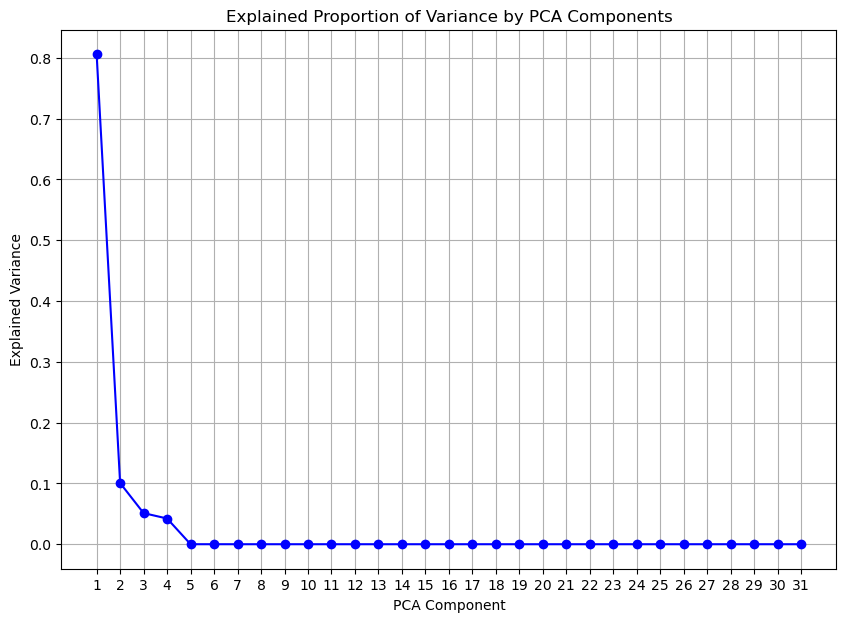

In [42]:
# Plot the explained variance
plt.figure(figsize=(10, 7))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    marker='o', linestyle='-', color='b')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance')
plt.title('Explained Proportion of Variance by PCA Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

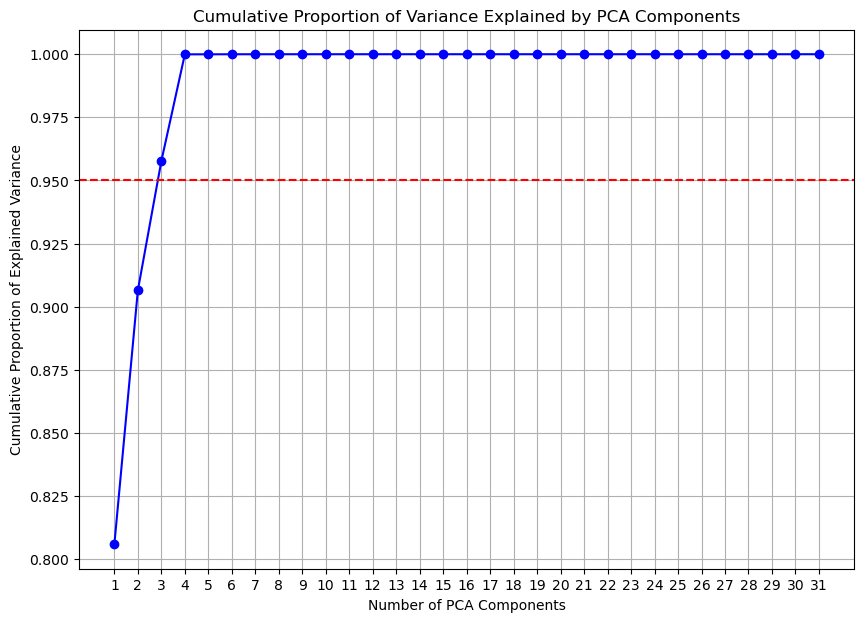

In [43]:
# Calculate cumulative sum of explained variances
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Cumulative Proportion of Variance Explained by PCA Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.axhline(y=0.95, color='r', linestyle='--')  # Optional: Line at 95% variance explained
plt.grid(True)

# Show the plot
plt.show()

## 5.2. PCA Model Performance

### 5.2.1 PCA with SVM

In [44]:
# Iterate over the different number of components
pca_svm_scores = {}
max_num_components = len(X_train.columns) + 1
for i in np.arange(1, max_num_components, 1):

    # Initialize the pipeline with PCA and SVM steps
    pca_svm_pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=i)), 
        ('svm', LinearSVC(dual='auto', max_iter=5000))
    ])

    pca_svm_scores[i] = cross_val_score(pca_svm_pipeline, X_train, y_train, cv=5, scoring='accuracy')


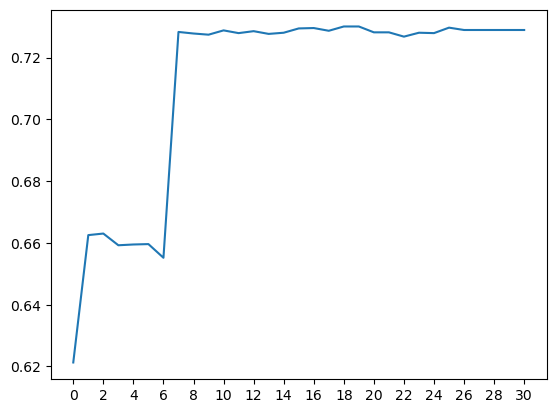

In [45]:
pca_svm_scores_means = [v.mean() for k, v in pca_svm_scores.items()]

fig, ax = plt.subplots()
ax.plot(pca_svm_scores_means)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.show()

### 5.2.2. PCA with Logistic Regression

In [46]:
# Iterate over the different number of components
pca_lr_scores = {}
max_num_components = len(X_train.columns) + 1
for i in np.arange(1, max_num_components, 1):

    # Initialize the pipeline with PCA and SVM steps
    pca_lr_pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=i)), 
        ('lr', LogisticRegression(max_iter=1000))
    ])

    pca_lr_scores[i] = cross_val_score(pca_lr_pipeline, X_train, y_train, cv=5, scoring='accuracy')

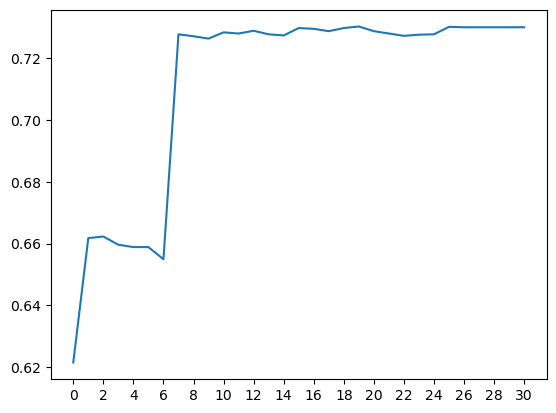

In [47]:
pca_lr_scores_means = [v.mean() for k, v in pca_lr_scores.items()]
fig, ax = plt.subplots()
ax.plot(pca_lr_scores_means)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.show()

# 6. Final Model

## 6.1. Evolutionary Algorithm Model Selection 

Below, I used evolutionary algorithm to tune the hyper-parameters of a linear SVM with PCA. For the mechanism of evolutionary algorithm, please refer to this [Wikipedia article](https://en.wikipedia.org/wiki/Evolutionary_algorithm) and the [sklearn-genetic-opt package](https://sklearn-genetic-opt.readthedocs.io/en/stable/) user guide.

In [48]:
# Evolutionary Algorithm package not installed
# Uncomment below code to install
# !pip install sklearn-genetic-opt

In [49]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

In [50]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA()), 
    ('svc', LinearSVC(dual='auto'))
])

# parameters for search
parameters = {
    'pca__n_components': Integer(5, 20),
    'svc__C': Continuous(0.1, 100)
}

# set up a kfold object
k_fold = KFold(n_splits=5, shuffle=True, random_state=24)

# set a search object
cv = GASearchCV(
    estimator=pipeline, 
    param_grid=parameters, 
    scoring="accuracy", 
    cv=k_fold,
    refit='accuracy',
    n_jobs=-1,
    population_size=5,
    generations=5,
    verbose = True
    )

# Fit the model
cv.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5     	0.712871	0.0291015  	0.728333   	0.654691   
1  	10    	0.72722 	0.000910101	0.728333   	0.726435   
2  	10    	0.728333	0          	0.728333   	0.728333   
3  	10    	0.728333	0          	0.728333   	0.728333   
4  	10    	0.728333	0          	0.728333   	0.728333   
5  	10    	0.728333	0          	0.728333   	0.728333   


GASearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('pca', PCA(n_components=19)),
                                     ('svc',
                                      LinearSVC(C=39.54020035693047,
                                                dual='auto'))]),
           generations=5, n_jobs=-1,
           param_grid={'pca__n_components': <sklearn_genetic.space.space.Integer object at 0x168d8e250>,
                       'svc__C': <sklearn_genetic.space.space.Continuous object at 0x168d8dc50>},
           population_size=5, refit='accuracy', return_train_score=True,
           scoring='accuracy')

In [51]:
# Print best parameters
cv.best_params_

{'pca__n_components': 19, 'svc__C': 39.54020035693047}

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       983
           1       0.74      0.74      0.74       993

    accuracy                           0.74      1976
   macro avg       0.74      0.74      0.74      1976
weighted avg       0.74      0.74      0.74      1976



<Axes: >

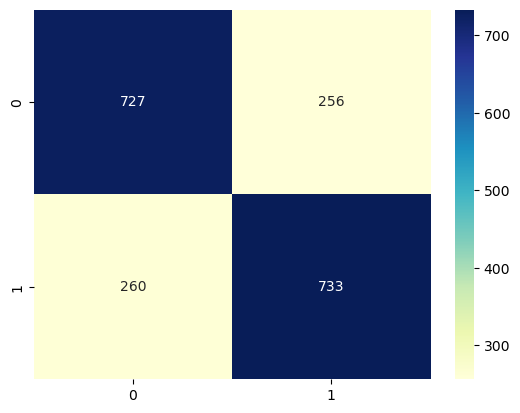

In [52]:
# Print Evaluation metrics
y_preds = cv.predict(X_test)
print(metrics.classification_report(y_test, y_preds))

# Confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(conf_mat)
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

## 6.2. BUT!

To be honest, I think a simple linear SVM with all features will perform similarly. The code below verified my thought...

In [53]:
svm_pipeline = make_pipeline(MinMaxScaler(), LinearSVC(dual='auto', max_iter=5000))
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearsvc', LinearSVC(dual='auto', max_iter=5000))])

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       983
           1       0.73      0.73      0.73       993

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976



<Axes: >

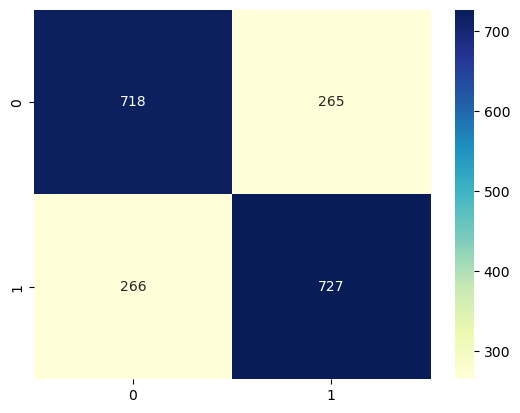

In [54]:
# Print Evaluation metrics
y_preds = svm_pipeline.predict(X_test)
print(metrics.classification_report(y_test, y_preds))

# Confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(conf_mat)
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

# 7. Conclusion

Based on the first 10 minutes game statistics, an ML can at best predict the winnig team of League of Legends with ~0.73 accuracy. This seems to be one of the best score that a model can achieve based on this dataset, among the code examples found in the [forum](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min/code). A [conference paper](https://ieeexplore.ieee.org/document/9763608) by Shen (2022) used similar data and ML algorithms also achieved simialr result.

Moreover, feature selection, dimensionality reduction, and evolutonary algorithm of model selection do not significantly improve the model. As long as the gold difference between two teams is included in the model prediction, the model can achieve around 0.72 accuracy.

Finally, [Do et al. (2021)](https://arxiv.org/abs/2108.02799#:~:text=Using%20a%20deep%20neural%20network,for%20playing%20LoL%20and%20matchmaking.) used deep learning models for a similar task but with the data on selected player-champions at the beginning of the game. The model achieved ~0.75 accuracy without any other data. To improve the ML algorithm for this project, it might be helpful to scrape the data on champinion choices from the API using game IDs.

# References

1. Q. Shen, "A machine learning approach to predict the result of League of Legends," 2022 International Conference on Machine Learning and Knowledge Engineering (MLKE), Guilin, China, 2022, pp. 38-45, doi: 10.1109/MLKE55170.2022.00013.
2. Do, T. D., Wang, S. I., Yu, D. S., McMillian, M. G., & McMahan, R. P. (2021, August). Using machine learning to predict game outcomes based on player-champion experience in League of Legends. In Proceedings of the 16th International Conference on the Foundations of Digital Games (pp. 1-5).
3. https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min
